# Single or mutiple flowline
Hereafter I'll look at the difference between a single flowline and a multiple flowline model, as usual compared to the length change measurements.

In [1]:
%%javascript
// Run model with multiple flowlines and store output
var i;
for(i=2; i<30; i++) {
    Jupyter.notebook.execute_cells([i]);
}

// Run model again, but with single flowline and store output
for(i=6; i<28; i++) {
    Jupyter.notebook.execute_cells([i]);
}

// run through rest of cells, combining lenght records and
// plotting results
for(i=30; i<34; i++) {
    Jupyter.notebook.execute_cells([i]);
}

<IPython.core.display.Javascript object>

## Import

In [2]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# import OGGM modules
import oggm
from oggm import cfg, graphics, utils
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, massbalance, flowline, inversion

## Initialize

In [3]:
# load default parameter file
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/working_example/'
cfg.PATHS['working_dir'] = wdir

# using intersects
cfg.PARAMS['use_intersects'] = True

# define big border
cfg.PARAMS['border'] = 50

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-04-16 14:23:21: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


## Preprocessing

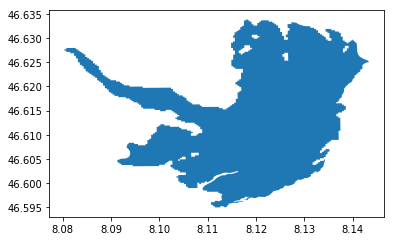

In [19]:
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]
rgi_df.plot()

In [20]:
# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

In [21]:
# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

### GIS

In [22]:
# GIS tasks
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)
gdir

2019-04-16 14:23:44: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-04-16 14:23:44: oggm.core.gis: (RGI60-11.01270) glacier_masks


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (192, 183)
  Grid (dx, dy): (52.0, -52.0)

### Centerlines

In [23]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-04-16 14:23:44: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-04-16 14:23:44: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-04-16 14:23:44: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-04-16 14:23:44: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-04-16 14:23:45: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-04-16 14:23:45: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-04-16 14:23:45: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-04-16 14:23:46: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


### Climate and mass balance parameters

In [24]:
# process the HistAlp climate file
climate.process_histalp_data(gdir)
climate.local_t_star(gdir)
climate.mu_star_calibration(gdir)

2019-04-16 14:23:46: oggm.core.climate: (RGI60-11.01270) process_histalp_data
2019-04-16 14:23:46: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-04-16 14:23:46: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909
2019-04-16 14:23:46: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


### Mass balance

In [25]:
# istance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

### Inversion

In [26]:
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

2019-04-16 14:23:46: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-04-16 14:23:46: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-04-16 14:23:46: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


2019-04-16 14:23:46: oggm.core.inversion: (RGI60-11.01270) distribute_thickness_interp
2019-04-16 14:23:46: oggm.core.gis: (RGI60-11.01270) interpolation_masks


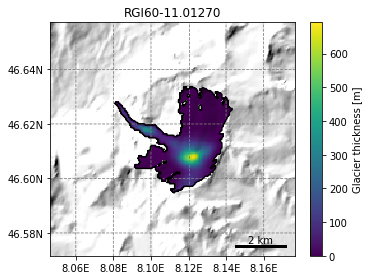

In [27]:
# visualize ice thickness
inversion.distribute_thickness_interp(gdir)
graphics.plot_distributed_thickness([gdir])

### Dynamic model

In [28]:
# finalize the preporcessing
flowline.init_present_time_glacier(gdir)

2019-04-16 14:23:48: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


## Model

In [29]:
# read needed file
ci =  gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

In [30]:
# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model, y0=ci['baseline_hydro_yr_0'])

In [31]:
# run model over entire HistAlp period
run_ds, diag_ds = model.run_until_and_store(2014)

## Results

In [17]:
# get modeled length changes as DataFrame (for multiple flowline)
length_multiple_fl = diag_ds.length_m.to_dataframe()[['hydro_year','length_m']]
length_multiple_fl = length_multiple_fl.reindex(index=length_multiple_fl.hydro_year)
length_multiple_fl.drop('hydro_year', axis=1, inplace=True)
length_multiple_fl.columns = ['multiple_fl']

In [18]:
# cell N° 29 (starting with 0)
cfg.PARAMS['use_multiple_flowlines'] = False

In [32]:
# get modeled length changes as DataFrame (for single flowline)
length_single_fl = diag_ds.length_m.to_dataframe()[['hydro_year','length_m']]
length_single_fl = length_single_fl.reindex(index=length_single_fl.hydro_year)
length_single_fl.drop('hydro_year', axis=1, inplace=True)
length_single_fl.columns = ['single_fl']

In [33]:
# get reference length
from oggm.grindel.utils import get_leclercq_length
length_ref = get_leclercq_length('11.01270')

In [34]:
# combine both records
length_df = pd.concat([length_ref, length_single_fl, length_multiple_fl], axis=1)
# reference year for length change measurements
year_ref_zero = length_ref.abs().idxmin()
# get mean modeled length at reference year
length_offset = length_df.loc[year_ref_zero, ['single_fl', 'multiple_fl']].mean(axis=1).iloc[0]
length_df.ref += length_offset

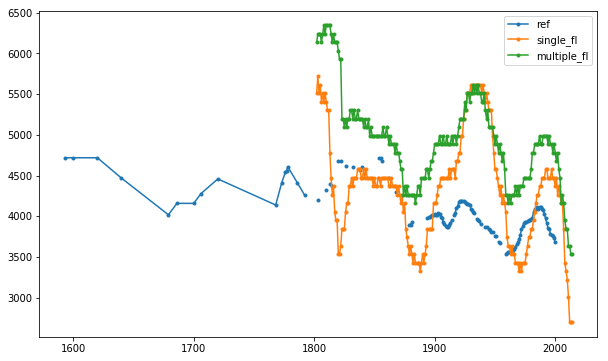

In [35]:
# plot lenght changes
length_df.plot(marker='.', figsize=[10,6])